In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# Replace 'Your spreadsheet name' with the actual name of your spreadsheet
# Replace 'Sheet1' with the name of the sheet you want to access
worksheet = gc.open('cancer patient data sets').worksheet('Sheet')

# Get all values from the worksheet
data = worksheet.get_all_values()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:

df = pd.DataFrame(data[1:], columns=data[0])
# Drop unnecessary columns and clean data
df.drop('Patient Id', axis=1, inplace=True)  # Drop Patient Id as it's not useful
df = df.replace('', np.nan).dropna()  # Handle missing values

# Encode categorical features
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Separate features and target variable
X = df.drop('Level', axis=1)
y = df['Level']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Basic KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # Default k=5
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.99

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      0.98      0.99        55
           2       0.98      1.00      0.99        63

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200


Confusion Matrix:
 [[82  0  0]
 [ 0 54  1]
 [ 0  0 63]]


**1.Feature Scaling:**
Scaling ensures all features contribute equally to the distance metric.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Re-train KNN with scaled data
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy after scaling: {accuracy:.2f}")


Accuracy after scaling: 1.00


**2. Hyperparameter Tuning:**
Using GridSearchCV to find the optimal number of neighbors.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Grid search for best k
param_grid = {'n_neighbors': np.arange(1, 31)}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best k
best_k = grid_search.best_params_['n_neighbors']
print(f"Optimal k: {best_k}")

# Train model with optimal k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with optimal k: {accuracy:.2f}")


Optimal k: 1
Accuracy with optimal k: 1.00


**3. Feature Selection:**
Selecting the most relevant features can improve accuracy.

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

# Feature selection
selector = SelectKBest(chi2, k=10)  # Select top 10 features
X_new = selector.fit_transform(X, y)

# Train/test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train KNN
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy after feature selection: {accuracy:.2f}")


Accuracy after feature selection: 1.00


**4. Cross-Validation:**
Ensures reliable accuracy by averaging over multiple splits.

In [ ]:
from sklearn.model_selection import cross_val_score

# Cross-validation
scores = cross_val_score(KNeighborsClassifier(n_neighbors=best_k), X_scaled, y, cv=5, scoring='accuracy')
print(f"Cross-validated accuracy: {scores.mean():.2f}")


Cross-validated accuracy: 1.00


In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation for KNN
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_scaled, y, cv=5, scoring='accuracy')  # 5-fold CV

print(f"Cross-validated Accuracy: {scores.mean():.2f}")
print("Individual Fold Accuracies:", scores)


Cross-validated Accuracy: 1.00
Individual Fold Accuracies: [1. 1. 1. 1. 1.]


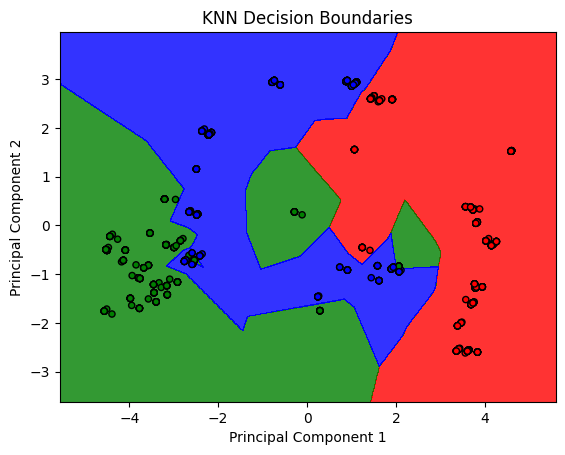

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# Reduce features to 2 for visualization (e.g., using PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Train KNN on the reduced dataset
knn.fit(X_pca, y)
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict on the mesh grid
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundaries
plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(('red', 'green', 'blue')))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='k', s=20, cmap=ListedColormap(('red', 'green', 'blue')))
plt.title("KNN Decision Boundaries")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


The visualization shows the decision boundaries of a KNN classifier in a 2D feature space, illustrating how it separates classes. Irregular boundaries suggest the model closely adapts to the data, which may indicate overfitting if `k` is too small. Correctly classified points lie within their respective regions, while misclassified points highlight areas of struggle. Overall, the plot provides a clear view of the classifier's performance and generalization ability.

**Implementation of random forest**

**Basic Random Forest Implementation**


In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train a basic Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Basic Random Forest Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Basic Random Forest Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00        55
           2       1.00      1.00      1.00        63

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Confusion Matrix:
 [[82  0  0]
 [ 0 55  0]
 [ 0  0 63]]


**Approaches to Improve Accuracy**

**1.Hyperparameter Tuning:**
We optimize the hyperparameters (e.g., number of trees, depth, and features) using GridSearchCV.

In [ ]:
# Hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           verbose=2)

grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Optimal parameters: {best_params}")

# Train with the best parameters
rf = RandomForestClassifier(**best_params, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with tuned Random Forest: {accuracy:.2f}")


Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[

In [ ]:
from sklearn.model_selection import cross_val_score

# Cross-validation
cv_scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='accuracy')
print(f"Cross-validated Accuracy: {cv_scores.mean():.2f}")


Cross-validated Accuracy: 1.00


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Ensemble model with Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('rf', rf),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42)),
    ('svc', SVC(probability=True, random_state=42))
], voting='soft')

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with Voting Classifier: {accuracy:.2f}")


Accuracy with Voting Classifier: 1.00


** Ensemble KNN and Random Forest**

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize KNN and Random Forest models
knn = KNeighborsClassifier(n_neighbors=5)  # Default KNN
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Default Random Forest

# Ensemble using Voting Classifier (Soft Voting)
voting_clf = VotingClassifier(estimators=[
    ('knn', knn),
    ('rf', rf)
], voting='soft')  # Use 'hard' for hard voting if preferred

# Fit the ensemble model
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred = voting_clf.predict(X_test)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Ensemble Model Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00        55
           2       1.00      1.00      1.00        63

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Confusion Matrix:
 [[82  0  0]
 [ 0 55  0]
 [ 0  0 63]]
